In [1]:
"""
Acknowledgements:
* The code is modified from https://github.com/SchwinnL/NeVA
* The Authors of this paper thank the Authors of NeVA for releasing the code.
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
import os
from math import exp

In [2]:
# Thiết lập seed để tái lập kết quả
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [3]:
# Tái tạo mô hình từ emotion_model.summary() trong PyTorch
class EmotionModel(nn.Module):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.dropout1 = nn.Dropout(0.25)  
        self.pool1 = nn.MaxPool2d(2, 2)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.dropout2 = nn.Dropout(0.25)  
        self.pool2 = nn.MaxPool2d(2, 2)   
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(0.25)  
        self.pool3 = nn.MaxPool2d(2, 2)   
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  
        self.dropout4 = nn.Dropout(0.25) 
        self.pool4 = nn.MaxPool2d(2, 2)  
        self.flatten = nn.Flatten()      
        self.fc1 = nn.Linear(256 * 3 * 3, 128)  
        self.dropout5 = nn.Dropout(0.5)   
        self.fc2 = nn.Linear(128, 3)      

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.dropout3(x)
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.dropout4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)  
        return x

In [4]:
# Class FovExWrapper
class FovExWrapper(nn.Module):
    def __init__(self, downstream_model, criterion, target_function, image_size, foveation_sigma, blur_filter_size, blur_sigma, forgetting, heatmap_sigma, heatmap_forgetting, foveation_aggregation=1, device="cuda"):
        super(FovExWrapper, self).__init__()
        self.image_size = image_size
        self.blur_filter_size = blur_filter_size
        self.blur_sigma = blur_sigma
        self.foveation_sigma = foveation_sigma
        self.forgetting = forgetting
        self.foveation_aggregation = foveation_aggregation
        self.internal_representation = None
        self.ones = None
        self.device = device
        self.downstream_model = downstream_model
        self.criterion = criterion
        self.target_function = target_function
        self.heatmap_sigma = heatmap_sigma
        self.heatmap_forgetting = heatmap_forgetting

    def forward(self, x, foveation_positions):
        if self.internal_representation is None:
            raise Exception("First set internal representation with function: initialize_scanpath_generation()")
        foveation_area = get_foveation(self.foveation_aggregation, self.foveation_sigma, self.image_size, foveation_positions)
        current_foveation_area = self.internal_representation + foveation_area
        blurring_mask = torch.clip(self.ones - current_foveation_area, 0, 1)
        applied_blur = self.blur * blurring_mask
        output = self.downstream_model(x + applied_blur)
        return output

    def initialize_scanpath_generation(self, x, batch_size):
        self.internal_representation = torch.zeros((batch_size, 1, self.image_size, self.image_size), device=self.device)
        self.ones = torch.ones((batch_size, 1, self.image_size, self.image_size), device=self.device)
        self.blur = calculate_blur(x, self.blur_filter_size, self.blur_sigma)

    def run_optimization(self, x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts=False):
        batch_size = x.size(0)
        targets = self.target_function(x, labels)
        self.initialize_scanpath_generation(x, batch_size)
        scanpath = []
        loss_history = []
        for _ in range(scanpath_length):
            foveation_pos = torch.zeros((batch_size, 2, 1, 1), device='cuda', requires_grad=True)
            best_foveation_pos = torch.zeros((batch_size, 2, 1, 1), device='cuda')
            best_loss = torch.ones((batch_size), device='cuda', dtype=torch.float32) * float("inf")
            for _ in range(opt_iterations):
                output = self(x, foveation_pos)
                loss = self.criterion(output, targets)
                total_loss = loss.mean()
                grad = torch.autograd.grad(total_loss, foveation_pos)[0]
                foveation_pos.data -= torch.sign(grad) * learning_rate
                idxs = loss < best_loss
                best_loss[idxs] = loss[idxs]
                best_foveation_pos[idxs] = foveation_pos[idxs]
                if torch.sum(~idxs) > 0:
                    if random_restarts:
                        foveation_pos.data[~idxs] = torch.rand_like(best_foveation_pos.data[~idxs]) * 2 - 1
                    else:
                        foveation_pos.data[~idxs] += torch.rand_like(best_foveation_pos.data[~idxs]) * learning_rate - learning_rate / 2
            current_foveation_mask = get_foveation(self.foveation_aggregation, self.foveation_sigma, self.image_size, best_foveation_pos)
            self.internal_representation = (self.internal_representation * self.forgetting + current_foveation_mask).detach()
            scanpath.append(best_foveation_pos.detach())
            loss_history.append(loss.detach())
        return torch.stack(scanpath, 1).squeeze(), torch.stack(loss_history, 1).squeeze(), self.internal_representation

    def generate_explanation(self, x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts=False, normalize_heatmap=True, seed=42):   
        set_seed(seed)   
        current_scanpaths, current_loss_history, internal_rep = self.run_optimization(x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts)
        heatmap = get_heat_maps(self.heatmap_sigma, self.image_size, current_scanpaths[None], self.heatmap_forgetting, self.device, normalize_heatmap)
        return heatmap, current_scanpaths, current_loss_history, internal_rep


In [5]:
# Các hàm hỗ trợ của FovEx
def calc_gaussian(a, std_dev, image_size, positions):
    B = positions.shape[0]
    xa, ya = create_grid(B, image_size)
    xa = xa - positions[:, 0]
    ya = ya - positions[:, 1]
    distance = (xa**2 + ya**2)
    g = a * torch.exp(-distance / std_dev)
    return g.view(B, 1, image_size, image_size)

def create_grid(batch_size, size):
    t = torch.linspace(-1, 1, size).cuda()
    xa, ya = torch.meshgrid([t, t])
    xa = xa.view(1, size, size).repeat(batch_size, 1, 1)
    ya = ya.view(1, size, size).repeat(batch_size, 1, 1)
    return xa, ya

def calculate_blur(images, blur_filter_size, sigma=5):
    def gaussian(window_size, sigma):
        gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
        return gauss / gauss.sum()
    def create_window(window_size, channel, sigma):
        _1D_window = gaussian(window_size, sigma).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
        return window
    window = create_window(blur_filter_size, 1, sigma).cuda()
    pad = nn.ReflectionPad2d(padding=blur_filter_size // 2)
    imgs_pad = pad(images)
    blured_images = F.conv2d(imgs_pad, window, groups=1)
    blur = blured_images - images
    return blur

def get_foveation(foveation_aggregation, foveation_sigma, image_size, positions):
    mask = calc_gaussian(foveation_aggregation, foveation_sigma, image_size, positions)
    return mask

def normalize(x):
    x = (x - x.min()) / (x.max() - x.min() + 1e-10)
    return x

def get_heat_maps(foveation_sigma, image_size, scanpaths, forgetting_factor, device, normalization):
    batch_size = scanpaths.shape[0]
    heat_map = torch.zeros((batch_size, 1, image_size, image_size)).to(device)
    for i in range(scanpaths.shape[1]):
        current_foveation_mask = get_foveation(1, foveation_sigma, image_size, scanpaths[:, i, :, None, None])
        heat_map = forgetting_factor[i] * heat_map + current_foveation_mask
    if normalization:
        heat_map = normalize(heat_map)
    return heat_map

In [6]:
# Tải và chuyển trọng số từ Keras sang PyTorch
def load_keras_weights_to_pytorch(pytorch_model, keras_model_path):
    keras_model = load_model(keras_model_path)
    keras_weights = keras_model.get_weights()
    state_dict = pytorch_model.state_dict()
    
    # Ánh xạ trọng số từ Keras sang PyTorch
    weight_map = [
        ('conv1.weight', 0, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),  # Keras: [H, W, In, Out] -> PyTorch: [Out, In, H, W]
        ('conv1.bias', 1, torch.tensor),
        ('conv2.weight', 2, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv2.bias', 3, torch.tensor),
        ('conv3.weight', 4, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv3.bias', 5, torch.tensor),
        ('conv4.weight', 6, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv4.bias', 7, torch.tensor),
        ('fc1.weight', 8, lambda w: torch.tensor(w.T)),  # Keras: [In, Out] -> PyTorch: [Out, In]
        ('fc1.bias', 9, torch.tensor),
        ('fc2.weight', 10, lambda w: torch.tensor(w.T)),
        ('fc2.bias', 11, torch.tensor),
    ]
    
    for (name, idx, transform) in weight_map:
        state_dict[name] = transform(keras_weights[idx])
    
    pytorch_model.load_state_dict(state_dict)
    return pytorch_model

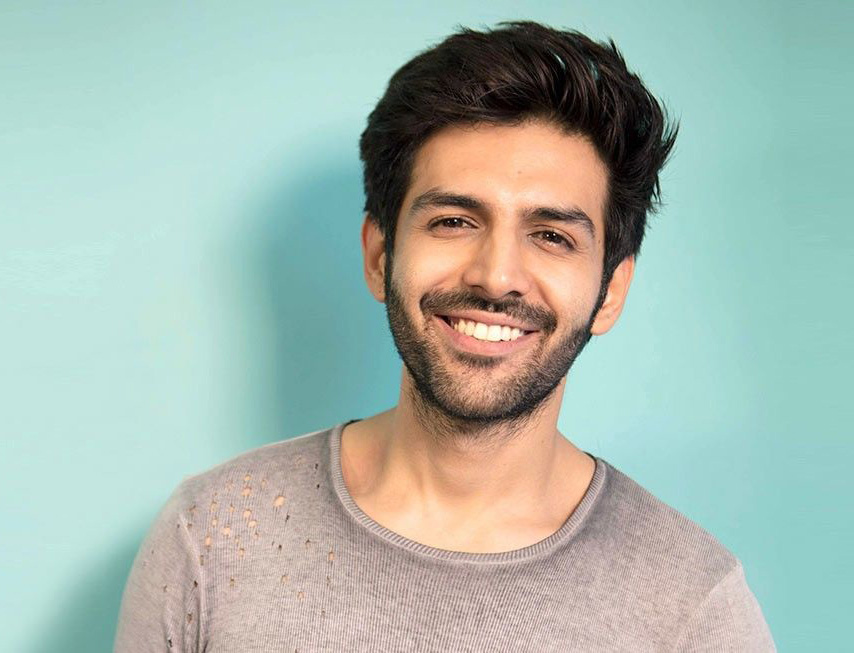

In [17]:
# Đường dẫn và khởi tạo mô hình
export_dir = 'D:/HUS_22001541/PPNCKH/output/emotion_model_pretrained.h5'
emotion_ranges = ['positive', 'negative', 'neutral']
img_path = "D:/HUS_22001541/PPNCKH/input/test_images/positive_img_02.jpg"

# Hiển thị ảnh gốc
pil_img = Image(filename=img_path)
display(pil_img)

# Tải và xử lý ảnh
test_image = cv2.imread(img_path)
if test_image is None:
    print("Lỗi: Không thể tải ảnh từ", img_path)
    exit()
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
emotion_img = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)
emotion_image_array = np.array(emotion_img, dtype=np.float32) / 255.0
emotion_input = torch.tensor(emotion_image_array).unsqueeze(0).unsqueeze(0).cuda()  # [1, 1, 48, 48]

In [18]:
# Khởi tạo và tải trọng số cho mô hình PyTorch
downstream_model = EmotionModel().cuda()
downstream_model = load_keras_weights_to_pytorch(downstream_model, export_dir)

In [19]:
# Dự đoán cảm xúc
with torch.no_grad():
    pred = downstream_model(emotion_input)
    pred_label = torch.argmax(pred, dim=1)
    output_emotion = emotion_ranges[pred_label.item()]
    print(f"Dự đoán cảm xúc: {output_emotion}")

Dự đoán cảm xúc: positive


In [20]:
# Khởi tạo FovExWrapper
criterion = nn.CrossEntropyLoss(reduction='none')
target_function = lambda x, y: y
fovex = FovExWrapper(
    downstream_model=downstream_model,
    criterion=criterion,
    target_function=target_function,
    image_size=48,
    foveation_sigma=0.2,
    blur_filter_size=11,
    blur_sigma=5,
    forgetting=0.9,
    heatmap_sigma=0.1,
    heatmap_forgetting=[0.9] * 5,
    device="cuda"
)

# Tạo heatmap bằng FovEx
heatmap, scanpaths, loss_history, internal_rep = fovex.generate_explanation(
    x=emotion_input,
    labels=pred_label,
    scanpath_length=5,
    opt_iterations=50,
    learning_rate=0.1,
    random_restarts=False,
    normalize_heatmap=True
)

# Phóng to heatmap về kích thước gốc
original_height, original_width = test_image.shape[:2]
heatmap_resized = F.interpolate(heatmap, size=(original_height, original_width), mode='bilinear', align_corners=False)
heatmap_np = heatmap_resized.squeeze().cpu().numpy()

# Chuẩn hóa và áp dụng colormap
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_np), cv2.COLORMAP_JET)

# Chồng heatmap lên ảnh gốc
superimposed_img = heatmap_color * 0.4 + test_image
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

Random seed set as 42


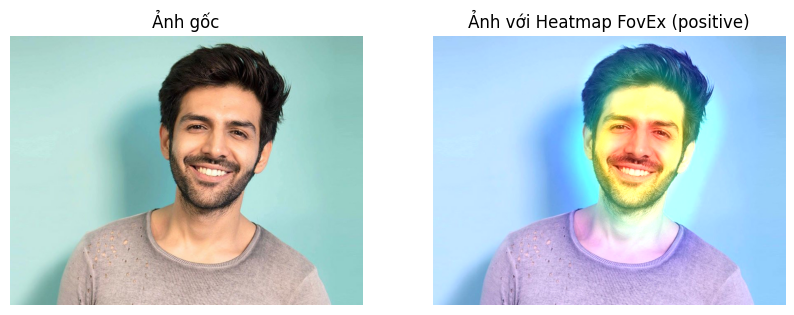

In [21]:
# Hiển thị kết quả
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Ảnh gốc")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Ảnh với Heatmap FovEx ({output_emotion})")
plt.axis('off')
plt.show()